In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [3]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [4]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 24936 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796
Found 31 total samples


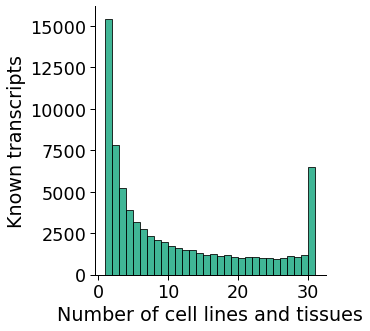

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
plot_biosamp_det(df,
                 how='iso',
                 min_tpm=1,
                 gene_subset='polya',
                 sample=None,
                 groupby='sample',
                 nov='Known',
                 opref='figures/human')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796
hewwo
                     gm12878_1_1  gm12878_1_2  gm12878_1_3  gm12878_1_4  \
annot_transcript_id                                                       
ENST00000469289.1            0.0          0.0          0.0          0.0   
ENST00000417324.1            0.0          0.0          0.0          0.0   
ENST00000461467.1            0.0          0.0          0.0          0.0   
ENST00000442987.3            0.0          0.0          0.0          0.0   
ENST00000494149.2            0.0          0.0          0.0          0.0   

                     gm12878_3_1  gm12878_2_1  gm12878_2_2  pgp1_1_1  \
annot_transcript_id                                                    
ENST00000469289.1            0.0          0.0          0.0  0.000000   
ENST00000417324.1            0.0          0.0          0.0  1.73762

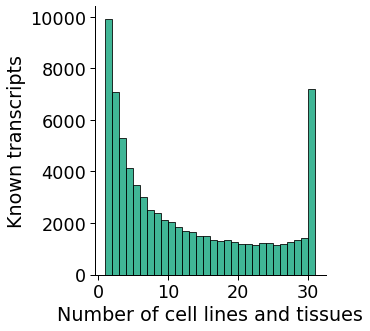

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')
print('hewwo')
print(df.head())
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = df.loc[df.annot_transcript_id.isin(tids)]
plot_biosamp_det(df,
                 how='iso',
                 sample=None,
                 nov='Known',
                 groupby='sample',
                 opref='figures/')

In [3]:
df.head()

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
0,4,6,ENSG00000243485.5,ENST00000469289.1,MIR1302-2HG,MIR1302-2HG-201,2,535,Known,Known,...,0,0,0,0,0,0,0,0,0,0
1,6,8,ENSG00000237613.2,ENST00000417324.1,FAM138A,FAM138A-201,3,1187,Known,Known,...,0,0,0,0,0,0,0,0,0,0
2,6,9,ENSG00000237613.2,ENST00000461467.1,FAM138A,FAM138A-202,2,590,Known,Known,...,0,0,0,0,0,0,0,0,0,0
3,12,21,ENSG00000233750.3,ENST00000442987.3,CICP27,CICP27-201,1,3812,Known,Known,...,0,0,0,0,0,0,0,0,0,0
4,13,22,ENSG00000268903.1,ENST00000494149.2,AL627309.6,AL627309.6-201,1,755,Known,Known,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
temp = df.copy(deep=True)

In [34]:
df = temp.copy(deep=True)

In [35]:
df = df
how = 'iso'
min_tpm = 1
gene_subset = 'polya'
sample = None
# groupby = 'sample' # sample or library
groupby = 'library' # sample or library
nov = 'Known'
opref = 'figures/human'

In [36]:
df, tids = get_tpm_table(df,
                   sample=sample,
                   how=how,
                   nov=[nov],
                   min_tpm=min_tpm,
                   gene_subset=gene_subset)

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [37]:
df = df.transpose()
df.index.name = 'dataset'
df.reset_index(inplace=True)

if groupby == 'sample':
    
    # add biosample name (ie without rep information)
    df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
    df.drop(['dataset'], axis=1, inplace=True)

    # record the highest TPM value per biosample
    tissue_df = get_tissue_metadata()
    tissue_df = tissue_df[['tissue', 'biosample']]

    df = df.merge(tissue_df, how='left', on='biosample')
    df.loc[df.tissue.isnull(), 'tissue'] = df.loc[df.tissue.isnull(), 'biosample']
    df.drop('biosample', axis=1, inplace=True)
    df.rename({'tissue': 'biosample'}, axis=1, inplace=True)

    print('Found {} total samples'.format(len(df.biosample.unique().tolist())))

    df = df.groupby('biosample').max()

elif groupby == 'library':
    
    df.rename({'dataset': 'library'}, axis=1, inplace=True)
    
    print('Found {} total libraries'.format(len(df.library.unique().tolist())))
    
    df = df.groupby('library').max()

Found 90 total libraries


In [38]:
df.head()

annot_transcript_id,ENST00000469289.1,ENST00000417324.1,ENST00000461467.1,ENST00000442987.3,ENST00000494149.2,ENST00000623083.4,ENST00000635159.1,ENST00000636676.1,ENST00000447954.2,ENST00000416931.1,...,ENST00000361789.2,ENST00000618686.1,ENST00000613230.1,ENST00000400754.4,ENST00000612465.1,ENST00000612565.1,ENST00000614336.4,ENST00000612315.1,ENST00000612848.1,ENST00000613204.1
library,,,,,,,,,,,,,,,,,,,,,
adrenal_gland_1_1,0.0,0.0,0.0,0.0,3.338798,6.677596,0.0,0.0,0.0,0.000000,...,263.765029,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.669399,25.040984
adrenal_gland_2_1,0.0,0.0,0.0,0.0,0.000000,12.716423,0.0,0.0,0.0,3.391046,...,64.429876,0.000000,9.325377,5.086569,0.000000,0.000000,0.0,0.0,0.000000,19.498515
adrenal_gland_3_1,0.0,0.0,0.0,0.0,0.000000,2.318728,0.0,0.0,0.0,0.000000,...,262.016226,0.000000,0.000000,0.000000,0.000000,4.637455,0.0,0.0,0.000000,55.649464
aorta_1_1,0.0,0.0,0.0,0.0,0.888667,22.216673,0.0,0.0,0.0,0.000000,...,87.089358,0.000000,7.998002,0.000000,0.888667,0.000000,0.0,0.0,1.777334,6.220668
aorta_2_1,0.0,0.0,0.0,0.0,6.984947,13.969895,0.0,0.0,0.0,0.000000,...,841.686166,3.492474,6.984947,6.984947,0.000000,0.000000,0.0,0.0,0.000000,13.969895


In [39]:

# finally, calculate the number of biosamples these transcripts
# are expressed >= min TPM
df = df.transpose()
df['n_samples'] = (df >= min_tpm).astype(int).sum(axis=1)

In [40]:
df.head()

library,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,cardiac_septum_1_1,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,...,right_cardiac_atrium_1_1,right_cardiac_atrium_2_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,n_samples
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000469289.1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
ENST00000417324.1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
ENST00000461467.1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ENST00000442987.3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ENST00000494149.2,3.338798,0.0,0.0,0.888667,6.984947,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21


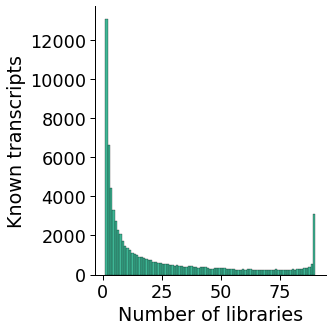

In [41]:
sns.set_context('paper', font_scale=2)

c_dict, order = get_talon_nov_colors()
color = c_dict[nov]
ax = sns.displot(data=df, x='n_samples', kind='hist',
                 color=color, binwidth=1)

# titles
if how == 'gene':
    ylabel = 'Known genes'
elif how == 'iso':
    if nov == 'Known':
        ylabel = 'Known transcripts'
    elif nov == 'NIC':
        ylabel = 'NIC transcripts'
    elif nov == 'NNC':
        ylabel = 'NNC transcripts'

if groupby == 'sample':
    xlabel = 'Number of cell lines and tissues'
elif groupby == 'tissue':
    xlabel = 'Number of tissues'
elif groupby == 'cell_line':
    xlabel = 'Number of celltypes'
elif groupby == 'library':
    if sample == 'cell_line':
        xlabel = 'Number of cell line libraries'
    elif sample == 'tissue':
        xlabel = 'Number of tissue libraries'
    else: 
        xlabel = 'Number of libraries'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)

if groupby == sample:
    fname = '{}{}_{}_{}_detection.png'.format(opref, sample, nov, how)
else:
    fname = '{}{}_{}_{}_library_detection.png'.format(opref, sample, nov, how)

plt.savefig(fname, dpi=300, bbox_inches='tight') 

In [10]:
df.head()

biosample,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,n_samples
ENST00000469289.1,0.0,0.000000,1.523717,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.835489,0.000000,2
ENST00000417324.1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.737626,0.000000,0.000000,0.000000,0.000000,1
ENST00000461467.1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.737626,0.000000,0.000000,0.000000,0.000000,1
ENST00000442987.3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,1.851643,0.000000,0.000000,0.000000,1
ENST00000494149.2,0.0,3.338798,0.000000,0.0,1.435431,0.0,2.926304,0.0,0.0,0.0,...,0.0,0.0,0.0,20.877595,6.475185,3.703285,6.522207,3.670978,6.984947,14


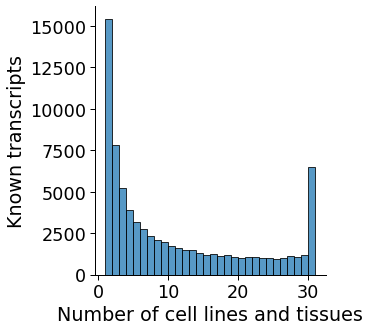

In [8]:
opref = 'figures/'

sns.set_context('paper', font_scale=2)

ax = sns.displot(data=df, x='n_samples', kind='hist', binwidth=1)
# ax = sns.displot(data=temp, x='length', kind='kde', 
#                  linewidth=3)

xlabel = 'Number of cell lines and tissues'
ylabel = 'Known transcripts'
# _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,10000))
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('{}_iso_det_1_tpm_biosample.pdf'.format(opref), \
            dpi=300, bbox_inches='tight')

## Length of transcripts from polyA genes detected >= 1 TPM

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


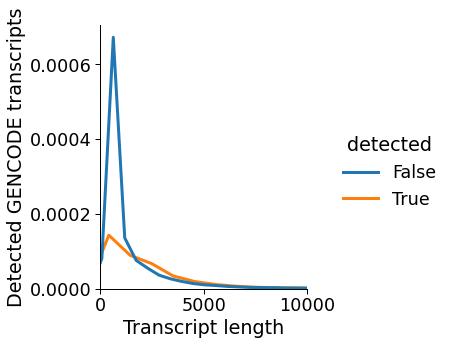

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [41]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [42]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000469289.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000417324.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,1.618796,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000461467.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000442987.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000494149.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,6.475185,1.242064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## How many known polyA transcripts do we detect?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [8]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 74796 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [13]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

tids = df.index.tolist()

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


  transcript_novelty  counts
0              Known   73961
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 98027


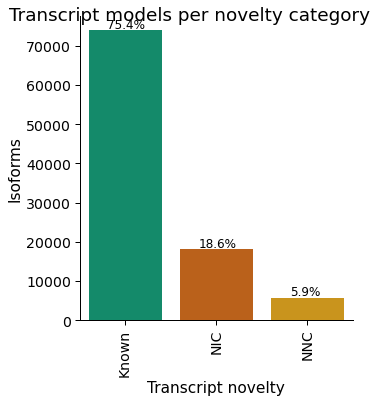

<Figure size 432x288 with 0 Axes>

In [16]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many isoforms per gene do we detect per sample? 

In [30]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')
t_df, _, _ = get_gtf_info(how='iso', subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


In [31]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000469289.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000417324.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.674708,1.563304,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000461467.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.674708,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000442987.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000494149.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.674708,6.253215,1.160702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
t_df.head()

,tid,t_len,biotype,biotype_category
0,ENST00000000233.9,1103,protein_coding,protein_coding
1,ENST00000000412.7,2756,protein_coding,protein_coding
2,ENST00000000442.10,2215,protein_coding,protein_coding
3,ENST00000001008.5,3732,protein_coding,protein_coding
4,ENST00000001146.6,4732,protein_coding,protein_coding
